# Forecast Airlines Passengers data set. Explain how many dummy variables you have created and RMSE value for each model. Finally which model you will use for Forecasting.
---

## Data Gathering

In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Loading the dataset
df = pd.read_excel("Airlines+Data.xlsx", parse_dates=True, index_col = 'Month')
df

,Passengers
Month,
1995-01-01,112
1995-02-01,118
1995-03-01,132
1995-04-01,129
1995-05-01,121
...,...
2002-08-01,405
2002-09-01,355
2002-10-01,306


## Data Exploration

In [3]:
# Checking for na values
df.isna().sum()

Passengers    0
dtype: int64

no na values

In [4]:
# Checking for duplicates
df[df.duplicated()]

,Passengers
Month,
1995-08-01,148
1995-12-01,118
1996-04-01,135
1996-08-01,170
1997-06-01,178
1997-08-01,199
1998-11-01,172
1999-02-01,196
1999-11-01,180


In [5]:
df.index.nunique()

96

In [6]:
df.shape

(96, 1)

Every entry is unique as we can see that every entry has a unique date. The number of Passengers is repeated sometimes, hence df.duplicated() considers these values as duplicates. We will not drop these values.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 96 entries, 1995-01-01 to 2002-12-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Passengers  96 non-null     int64
dtypes: int64(1)
memory usage: 3.6 KB


We have 96 samples

In [8]:
df.describe()

,Passengers
count,96.000000
mean,213.708333
std,71.918216
min,104.000000
25%,156.000000
50%,200.000000
75%,264.750000
max,413.000000


## Data Visualization

Text(0.5, 1.0, 'Time series of No. of Passengers')

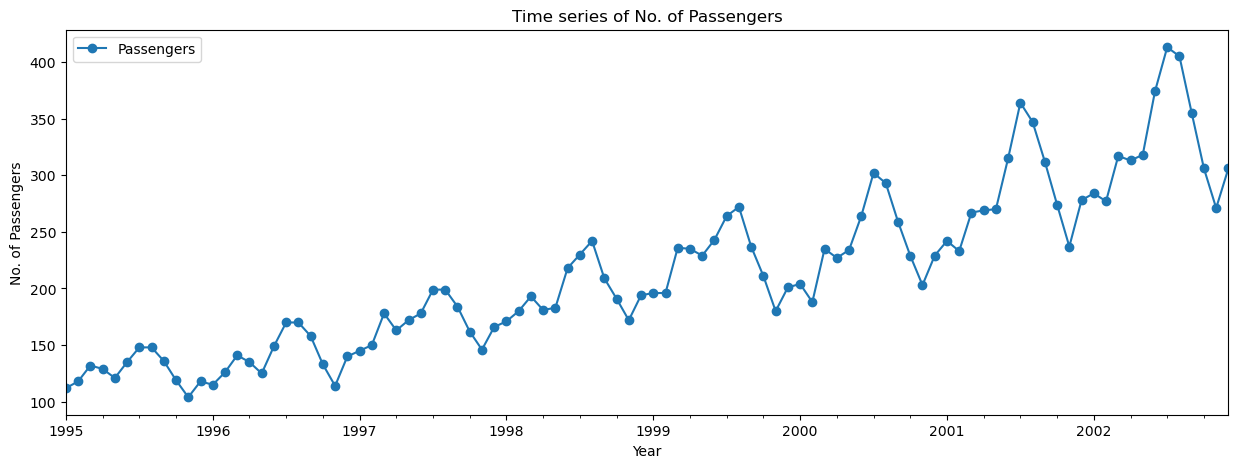

In [9]:
# Lineplot
df.plot(figsize=(15, 5), marker = 'o')
plt.xlabel('Year')
plt.ylabel('No. of Passengers')
plt.title('Time series of No. of Passengers')

We can see an upward trend and multiplicative seasonality from this plot. Hence, the data is not stationary.

<Axes: xlabel='Passengers', ylabel='Count'>

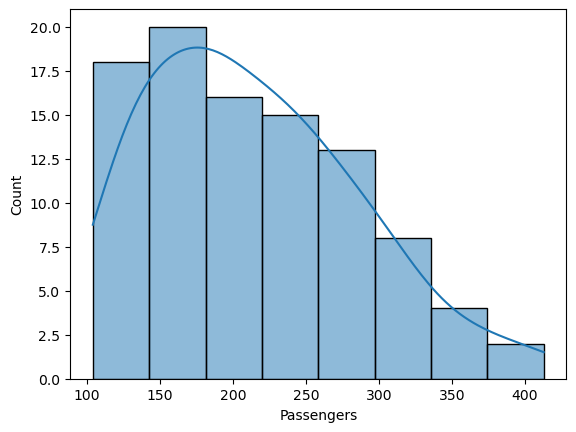

In [10]:
# Histplot with kde
sns.histplot(df, x = 'Passengers', kde = True)

Series is right skewed. We will use transformations to make the series stationary.

In [11]:
# Extracting year and month
df["month"] = df.index.strftime("%b")
df["year"] = df.index.strftime("%Y")

<Axes: xlabel='month', ylabel='year'>

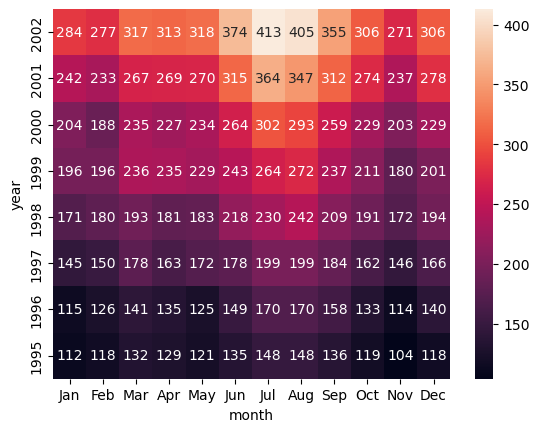

In [12]:
# Pivoting the time series to get a year by month matrix with passengers as values ,aggfunc="mean",fill_value=0
passengers_every_month = pd.pivot_table(data=df,values="Passengers",index="year",columns="month")

# Setting order of months
passengers_every_month = passengers_every_month[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]

# Sorting by year descending
passengers_every_month.sort_index(ascending=False, inplace=True)

# Heatmap
sns.heatmap(passengers_every_month,annot=True,fmt="g")

We have higher values as each year passes, and june, july, august, september have higher values than rest

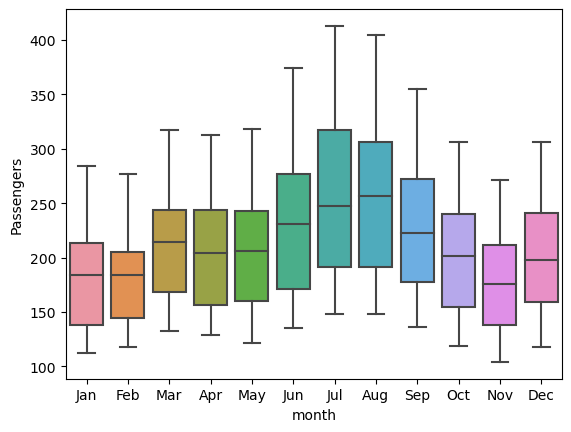

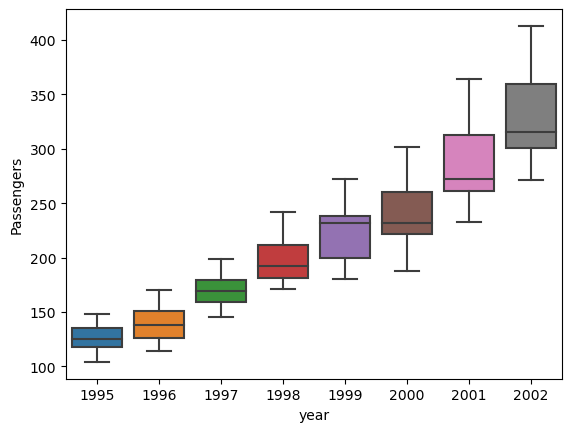

In [13]:
# Boxplots for month and year

sns.boxplot(df, x = 'month', y = 'Passengers')
plt.show()
sns.boxplot(df, x = 'year', y = 'Passengers')
plt.show()

Every year we have an upward trend in number of passengers. We can see seasonality from boxplot for month. We have a peak at August and trough at November.

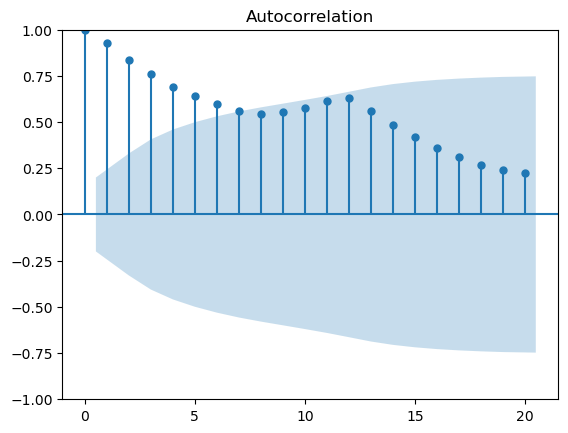

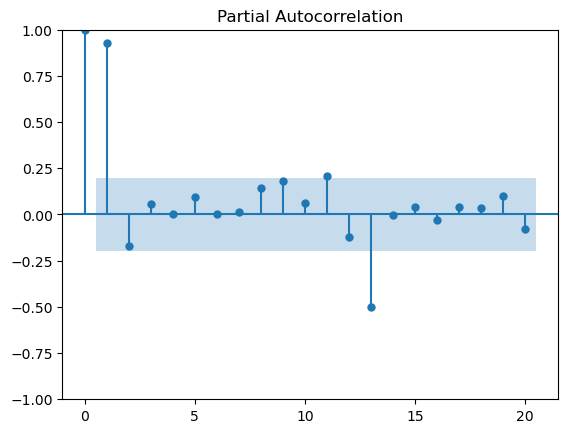

In [14]:
# Autocorrelation and Partial Autocorrelation plot

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df.Passengers)
plt.show()
plot_pacf(df.Passengers)
plt.show()

We can see high correlation for month and year in PACF plot.

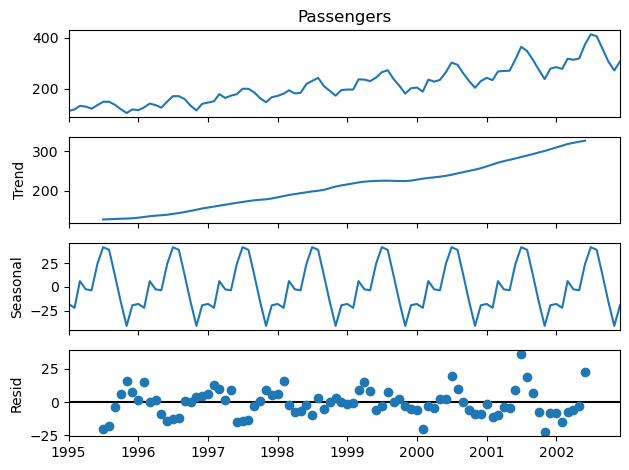

In [15]:
# Getting timeseries decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_decompose(df['Passengers']).plot()
plt.show()

## Feature Engineering

In [16]:
# Adding a timeseries index as a column
df['t'] = [i for i in range(1, df.shape[0] + 1)]

In [17]:
df['t_sqrd'] = df.t.apply(lambda x : x**2)

In [18]:
df

,Passengers,month,year,t,t_sqrd
Month,,,,,
1995-01-01,112,Jan,1995,1,1
1995-02-01,118,Feb,1995,2,4
1995-03-01,132,Mar,1995,3,9
1995-04-01,129,Apr,1995,4,16
1995-05-01,121,May,1995,5,25
...,...,...,...,...,...
2002-08-01,405,Aug,2002,92,8464
2002-09-01,355,Sep,2002,93,8649
2002-10-01,306,Oct,2002,94,8836


In [19]:
# Getting dummy columns for month
months = pd.get_dummies(df['month'])
months = months[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov']]
df = pd.concat([df,months],axis=1)

We want to make our data stationary.

In [20]:
from statsmodels.tsa.stattools import adfuller

# define function to check stationarity using ADF test and plot rolling mean and standard deviation along timeseries
def adf_test(timeseries):
    """
    Performs Augmented Dickey-Fuller test on given time series
    """
    print('Results of Augmented Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    roll = int(dfoutput['#Lags Used'])
    rolling_mean=timeseries.rolling(roll).mean()
    rolling_std = timeseries.rolling(roll).std()
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

Results of Augmented Dickey-Fuller Test:
Test Statistic                  1.340248
p-value                         0.996825
#Lags Used                     12.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


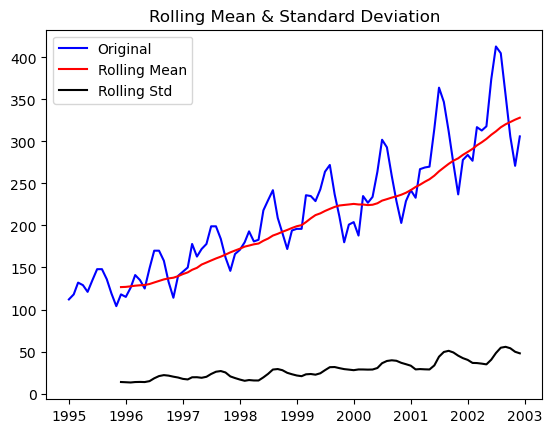

In [21]:
adf_test(df['Passengers'])

Our data could have linear, or exponential trend and has multiplicative seasonality. We want a p-value of atmost 0.05 to conclude that the data is stationary.

Results of Augmented Dickey-Fuller Test:
Test Statistic                  0.451435
p-value                         0.983320
#Lags Used                     12.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


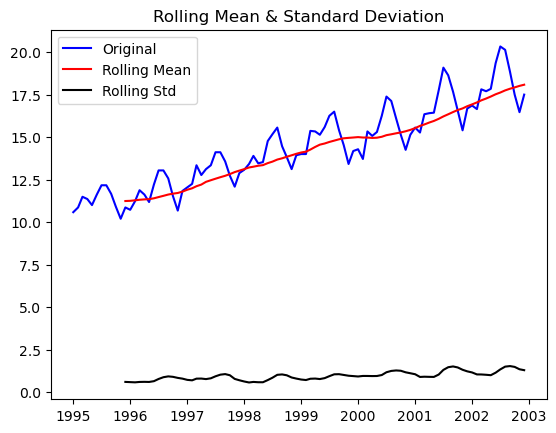

In [22]:
# Applying square root transformation
df['sqrt_Passengers'] = np.sqrt(df['Passengers'])
adf_test(df['sqrt_Passengers'])

Results of Augmented Dickey-Fuller Test:
Test Statistic                 -2.534817
p-value                         0.107231
#Lags Used                     12.000000
Number of Observations Used    82.000000
Critical Value (1%)            -3.512738
Critical Value (5%)            -2.897490
Critical Value (10%)           -2.585949
dtype: float64


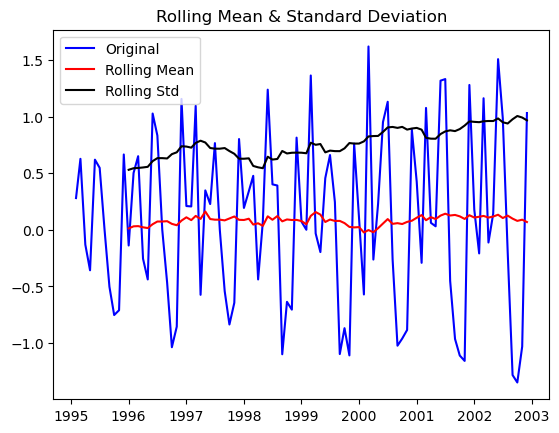

In [23]:
adf_test(df['sqrt_Passengers'].diff(1).dropna())

Results of Augmented Dickey-Fuller Test:
Test Statistic                 -0.723027
p-value                         0.840695
#Lags Used                     12.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


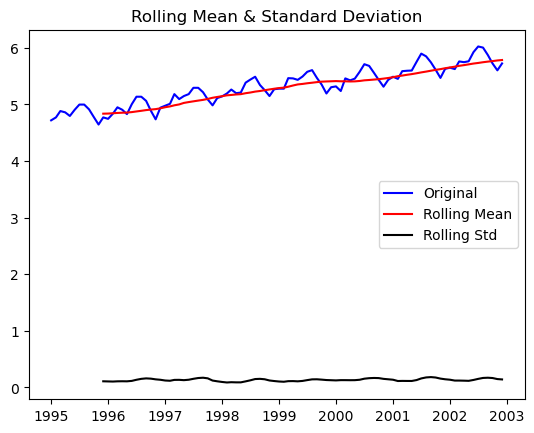

In [24]:
# Applying log transformation
df['log_Passengers'] = np.log(df['Passengers'])
adf_test(df['log_Passengers'])

Results of Augmented Dickey-Fuller Test:
Test Statistic                 -2.670823
p-value                         0.079225
#Lags Used                     12.000000
Number of Observations Used    82.000000
Critical Value (1%)            -3.512738
Critical Value (5%)            -2.897490
Critical Value (10%)           -2.585949
dtype: float64


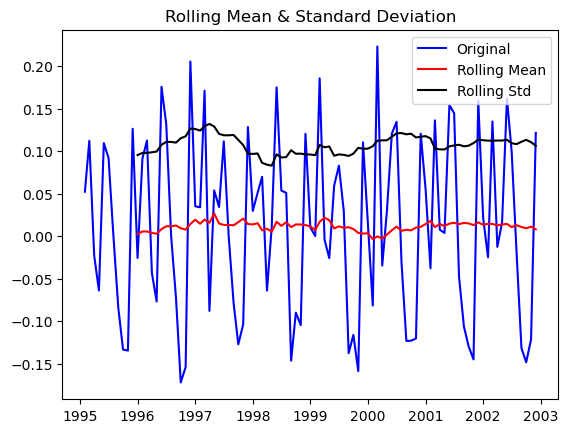

In [25]:
adf_test(df['log_Passengers'].diff(1).dropna())

While not less than 0.05, we came close to 0.07 with differencing for log transformation of passengers

In [26]:
# Creating another dataframe for stationary data
df_st = df.copy()
df_st['log_diff_Passengers'] = df_st['log_Passengers'].diff(1)
df_st.dropna(inplace = True)

In [27]:
df.tail(15)

,Passengers,month,year,t,t_sqrd,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,sqrt_Passengers,log_Passengers
Month,,,,,,,,,,,,,,,,,,
2001-10-01,274,Oct,2001,82,6724,0,0,0,0,0,0,0,0,0,1,0,16.552945,5.613128
2001-11-01,237,Nov,2001,83,6889,0,0,0,0,0,0,0,0,0,0,1,15.394804,5.468060
2001-12-01,278,Dec,2001,84,7056,0,0,0,0,0,0,0,0,0,0,0,16.673332,5.627621
2002-01-01,284,Jan,2002,85,7225,1,0,0,0,0,0,0,0,0,0,0,16.852300,5.648974
2002-02-01,277,Feb,2002,86,7396,0,1,0,0,0,0,0,0,0,0,0,16.643317,5.624018
2002-03-01,317,Mar,2002,87,7569,0,0,1,0,0,0,0,0,0,0,0,17.804494,5.758902
2002-04-01,313,Apr,2002,88,7744,0,0,0,1,0,0,0,0,0,0,0,17.691806,5.746203
2002-05-01,318,May,2002,89,7921,0,0,0,0,1,0,0,0,0,0,0,17.832555,5.762051
2002-06-01,374,Jun,2002,90,8100,0,0,0,0,0,1,0,0,0,0,0,19.339080,5.924256


We want to get the months for 2002 in the validation set

In [28]:
train_df = df.head(df.shape[0] - 12)
test_df = df.tail(12)

train_df_st = df_st.head(df_st.shape[0] - 12)
test_df_st = df_st.tail(12)

In [29]:
train_df.tail(2)

,Passengers,month,year,t,t_sqrd,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,sqrt_Passengers,log_Passengers
Month,,,,,,,,,,,,,,,,,,
2001-11-01,237,Nov,2001,83,6889,0,0,0,0,0,0,0,0,0,0,1,15.394804,5.468060
2001-12-01,278,Dec,2001,84,7056,0,0,0,0,0,0,0,0,0,0,0,16.673332,5.627621


In [30]:
test_df.head(2)

,Passengers,month,year,t,t_sqrd,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,sqrt_Passengers,log_Passengers
Month,,,,,,,,,,,,,,,,,,
2002-01-01,284,Jan,2002,85,7225,1,0,0,0,0,0,0,0,0,0,0,16.852300,5.648974
2002-02-01,277,Feb,2002,86,7396,0,1,0,0,0,0,0,0,0,0,0,16.643317,5.624018


In [31]:
train_df_st.tail(2)

,Passengers,month,year,t,t_sqrd,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,sqrt_Passengers,log_Passengers,log_diff_Passengers
Month,,,,,,,,,,,,,,,,,,,
2001-11-01,237,Nov,2001,83,6889,0,0,0,0,0,0,0,0,0,0,1,15.394804,5.468060,-0.145068
2001-12-01,278,Dec,2001,84,7056,0,0,0,0,0,0,0,0,0,0,0,16.673332,5.627621,0.159561


In [32]:
test_df_st.head(2)

,Passengers,month,year,t,t_sqrd,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,sqrt_Passengers,log_Passengers,log_diff_Passengers
Month,,,,,,,,,,,,,,,,,,,
2002-01-01,284,Jan,2002,85,7225,1,0,0,0,0,0,0,0,0,0,0,16.852300,5.648974,0.021353
2002-02-01,277,Feb,2002,86,7396,0,1,0,0,0,0,0,0,0,0,0,16.643317,5.624018,-0.024957


We have correctly sepearated the training and testing sets

## Regression Models

In [33]:
import statsmodels.formula.api as smf

### For original data

In [34]:
model_scores = {}

In [35]:
# For linear regression
linear_model = smf.ols('Passengers~t',data=train_df).fit()
pred = linear_model.predict(test_df['t']).values
true = test_df['Passengers'].values
model_scores['org_df_linear_regression'] = np.sqrt(np.mean((true - pred)**2))

In [36]:
# For exponential regression
exp_model = smf.ols('log_Passengers~t',data=train_df).fit()
pred = exp_model.predict(test_df['t']).values
model_scores['org_df_exponential_regression'] = np.sqrt(np.mean((true - pred)**2))

In [37]:
# For quadratic regression
quad_model = smf.ols('Passengers~t+t_sqrd',data=train_df).fit()
pred = quad_model.predict(test_df.loc[:,["t", "t_sqrd"]]).values
model_scores['org_df_quadratic_regression'] = np.sqrt(np.mean((true - pred)**2))

In [38]:
# For Additive seasonality Linear
add_season_model = smf.ols('Passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data=train_df).fit()
pred = add_season_model.predict(test_df.loc[:,['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov']]).values
model_scores['org_df_additive_linear_regression'] = np.sqrt(np.mean((true - pred)**2))

In [39]:
#Additive Seasonality Quadratic 
add_season_quad_model = smf.ols('Passengers~t+t_sqrd+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data=train_df).fit()
pred = add_season_quad_model.predict(test_df.loc[:,['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','t','t_sqrd']]).values
model_scores['org_df_additive_quadratic_regression'] = np.sqrt(np.mean((true - pred)**2))

In [40]:
# Multiplicative Seasonality Linear
mul_season_model = smf.ols('log_Passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data=train_df).fit()
pred = mul_season_model.predict(test_df.loc[:,['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov']]).values
model_scores['org_df_multiplicative_linear_regression'] = np.sqrt(np.mean((true - pred)**2))

In [41]:
#Multiplicative Additive Seasonality 
mul_add_season_model = smf.ols('log_Passengers~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data=train_df).fit()
pred = mul_add_season_model.predict(test_df.loc[:,['t','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov']]).values
model_scores['org_df_multiplicative_and_additive_linear_regression'] = np.sqrt(np.mean((true - pred)**2))

### For stationary data

In [42]:
# For linear regression
linear_model = smf.ols('log_diff_Passengers~t',data=train_df_st).fit()
pred = linear_model.predict(test_df_st['t']).values
true = test_df_st['log_diff_Passengers'].values
model_scores['st_df_linear_regression'] = np.sqrt(np.mean((true - pred)**2))

In [43]:
# For exponential regression
exp_model = smf.ols('log_diff_Passengers~t',data=train_df_st).fit()
pred = exp_model.predict(test_df_st['t']).values
model_scores['st_df_exponential_regression'] = np.sqrt(np.mean((true - pred)**2))

In [44]:
# For quadratic regression
quad_model = smf.ols('log_diff_Passengers~t+t_sqrd',data=train_df_st).fit()
pred = quad_model.predict(test_df_st.loc[:,["t", "t_sqrd"]]).values
model_scores['st_df_quadratic_regression'] = np.sqrt(np.mean((true - pred)**2))

In [45]:
# For Additive seasonality Linear
add_season_model = smf.ols('log_diff_Passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data=train_df_st).fit()
pred = add_season_model.predict(test_df_st.loc[:,['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov']]).values
model_scores['st_df_additive_linear_regression'] = np.sqrt(np.mean((true - pred)**2))

In [46]:
#Additive Seasonality Quadratic 
add_season_quad_model = smf.ols('log_diff_Passengers~t+t_sqrd+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data=train_df_st).fit()
pred = add_season_quad_model.predict(test_df_st.loc[:,['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','t','t_sqrd']]).values
model_scores['st_df_additive_quadratic_regression'] = np.sqrt(np.mean((true - pred)**2))

In [47]:
pd.Series(model_scores).sort_values()

st_df_additive_linear_regression                          0.023728
st_df_additive_quadratic_regression                       0.023839
st_df_quadratic_regression                                0.101699
st_df_linear_regression                                   0.101724
st_df_exponential_regression                              0.101724
org_df_additive_quadratic_regression                     26.360818
org_df_quadratic_regression                              48.051889
org_df_linear_regression                                 53.199237
org_df_additive_linear_regression                       132.819785
org_df_multiplicative_and_additive_linear_regression    325.695249
org_df_exponential_regression                           325.715061
org_df_multiplicative_linear_regression                 326.226799
dtype: float64

We got the best score i.e. lowest rmse for additive linear for stationary dataset.

### Modelling on the entire stationary data

In [48]:
#Build the model on entire stationary data set for Additive Seasonality Linear

additive_linear_model = smf.ols('log_diff_Passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data=df_st).fit()
true = df_st.log_diff_Passengers.values
pred = additive_linear_model.predict(df_st.loc[:,['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov']]).values
errors = true - pred
print(f"RMSE : {np.sqrt(np.mean((errors)**2))}")

RMSE : 0.035233328853823284


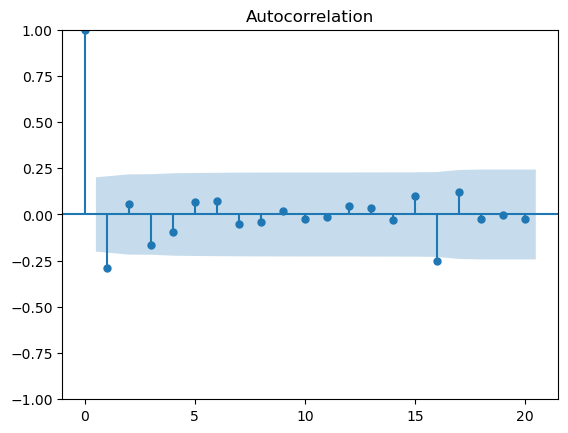

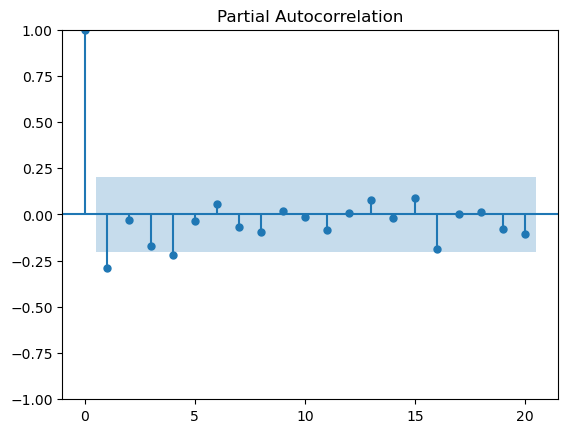

In [49]:
# Plotting ACF and PACF for the errors
plot_acf(errors)
plt.show()
plot_pacf(errors)
plt.show()

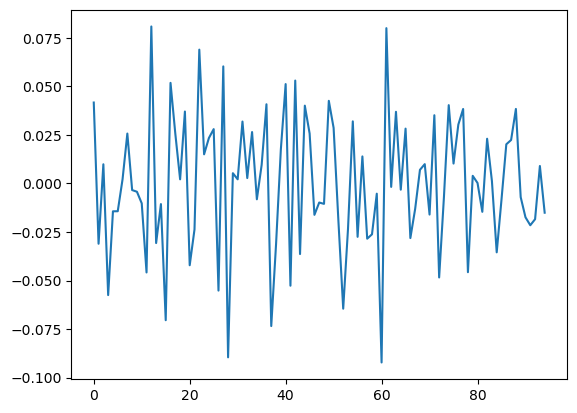

In [50]:
plt.plot(errors)

<Axes: ylabel='Count'>

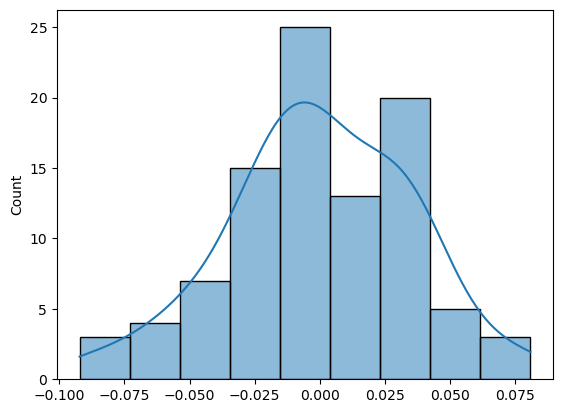

In [51]:
sns.histplot(x = errors, kde = True)

From the above error graphs, we can conclude that the errors have no pattern, and thus or model is optimal.

## Exponential Smoothing Models

In [52]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing

### For original data

Original data has trend as well as seasonality. Hence, we will use Holt-Winters Exponential Smoothing

In [53]:
hwe_mul_season_model = ExponentialSmoothing(train_df["Passengers"],seasonal="mul",trend="add",seasonal_periods=12).fit() 
true = test_df.Passengers.values
pred = hwe_mul_season_model.predict(start = test_df.index[0],end = test_df.index[-1])
np.sqrt(np.mean((true - pred)**2))

C:\Users\harsh\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


12.920904962268803

### For stationary data

In [54]:
# Simple Exponential Smoothing
ses_model = SimpleExpSmoothing(train_df_st["log_diff_Passengers"]).fit()
pred = ses_model.predict(start = test_df_st.index[0],end = test_df_st.index[-1])
true = test_df_st.log_diff_Passengers.values
np.sqrt(np.mean((true - pred)**2))

C:\Users\harsh\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


0.10187994217672386

In [55]:
# Holt’s Linear Exponential Smoothing
hles_model = Holt(train_df_st["log_diff_Passengers"]).fit()
pred = hles_model.predict(start = test_df_st.index[0],end = test_df_st.index[-1])
np.sqrt(np.mean((true - pred)**2))

C:\Users\harsh\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


0.10241508734391733

In [56]:
# Holt-Winters Exponential Smoothing with additive seasonality
hwes_model = ExponentialSmoothing(train_df_st["log_diff_Passengers"],seasonal="add",trend="add",seasonal_periods=12).fit()
pred = hwes_model.predict(start = test_df_st.index[0],end = test_df_st.index[-1])
np.sqrt(np.mean((true - pred)**2))

C:\Users\harsh\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


0.024070624363491784

Holt-Winters Exponential Smoothing with additive seasonality for stationary data gave the lowest rmse

### Modelling on the entire stationary data

In [57]:
#Build the Holt-Winters Exponential Smoothing model with additive seasonality on entire stationary data

hwes_model = ExponentialSmoothing(df_st["log_diff_Passengers"],seasonal="add",trend="add",seasonal_periods=12).fit()
true = df_st.log_diff_Passengers.values
pred = hwes_model.predict(start = df_st.index[0],end = df_st.index[-1])
errors = true - pred
print(f"RMSE : {np.sqrt(np.mean((errors)**2))}")

C:\Users\harsh\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


RMSE : 0.035233221064250315


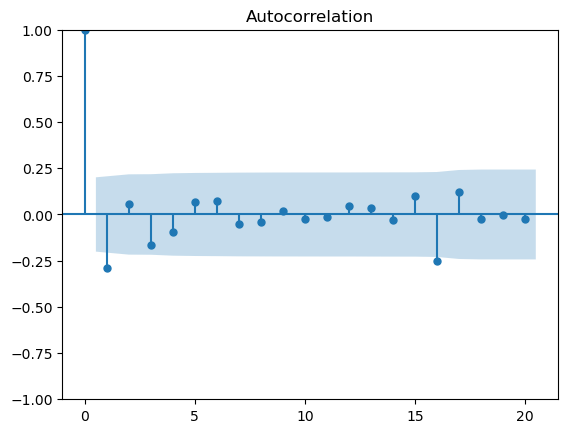

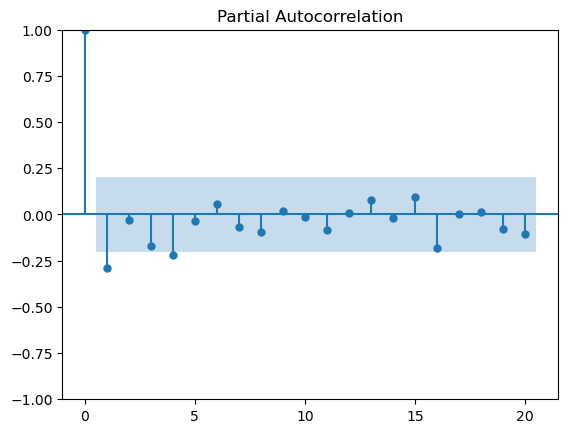

In [58]:
# Plotting ACF and PACF for the errors
plot_acf(errors)
plt.show()
plot_pacf(errors)
plt.show()

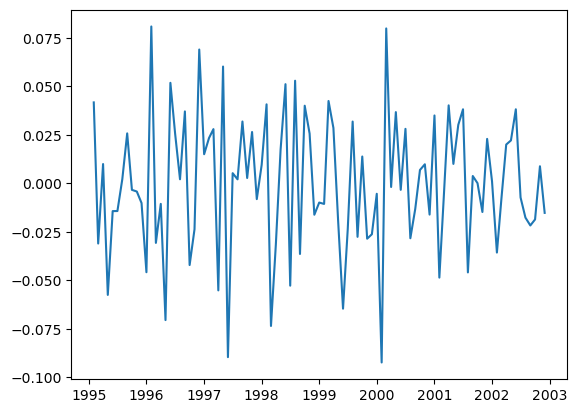

In [59]:
plt.plot(errors)

<Axes: ylabel='Count'>

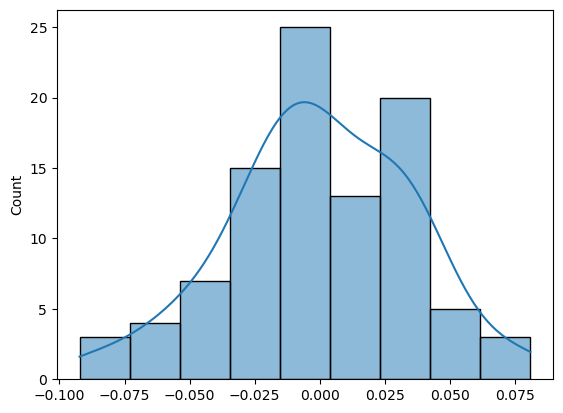

In [60]:
sns.histplot(x = errors, kde = True)

From the above error graphs, we can conclude that the errors have no pattern, and thus or model is optimal.

We got a fractionally better score (of the order 1e-7) than regression models

## ARIMA Model

ARIMA needs timeseries to be stationary. Hence, we will use stationary data

### Hyperparameter Tuning

In [61]:
from statsmodels.tsa.arima.model import ARIMA

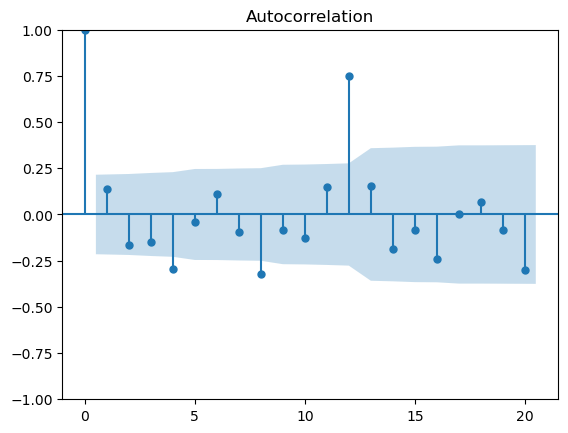

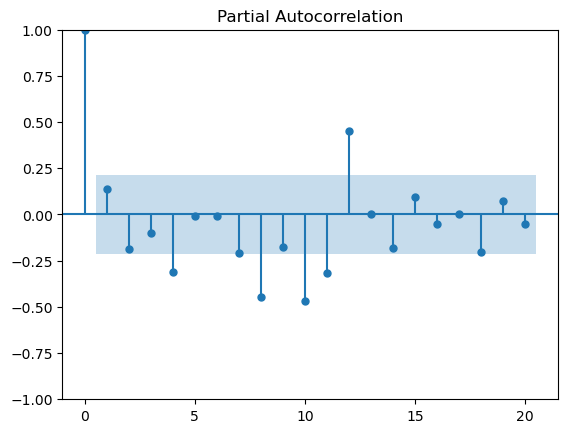

In [62]:
# Plotting ACF and PACF for the errors
plot_acf(train_df_st['log_diff_Passengers'])
plt.show()
plot_pacf(train_df_st['log_diff_Passengers'])
plt.show()

In [63]:
# Function to evaluate rmse for ARIMA model for passed order (p,d,q)
def evaluate_arima_model(arima_order):
    model = ARIMA(train_df_st['log_diff_Passengers'], order = arima_order).fit()
    true = test_df_st.log_diff_Passengers
    pred = model.forecast(steps=len(test_df_st.log_diff_Passengers)).values
    return np.sqrt(np.mean((true - pred)**2))

In [64]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(p_values, d_values, q_values):
    best_score, best_pdq = np.inf, None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(order)
                    if rmse < best_score:
                        best_score, best_pdq = rmse, order
                        print(f'RMSE={rmse} for order {order}')
                except:
                    continue
    print(f'Best Score\n===========\nRMSE={best_score} for order {best_pdq}')

In [65]:
import warnings
# Defining hyperparameters
p_values = range(1, 16)
d_values = range(1, 16)
q_values = range(1, 16)
warnings.filterwarnings("ignore")
evaluate_models(p_values, d_values, q_values)

RMSE=0.10194685424549377 for order (1, 1, 1)
RMSE=0.10044888444327565 for order (1, 1, 2)
RMSE=0.10033012516497757 for order (1, 1, 3)
RMSE=0.09733276872929279 for order (1, 1, 7)
RMSE=0.09535184830257397 for order (1, 1, 9)
RMSE=0.07661931883894911 for order (1, 1, 12)
RMSE=0.07328318967593773 for order (1, 1, 13)
RMSE=0.07294372323917442 for order (1, 1, 14)
RMSE=0.07128110169632815 for order (2, 1, 12)
RMSE=0.06980293675677551 for order (2, 1, 14)
RMSE=0.06777077360276736 for order (3, 1, 12)
RMSE=0.06493707760218476 for order (4, 1, 12)
RMSE=0.06475488172628077 for order (7, 4, 15)
RMSE=0.057725340016678825 for order (8, 1, 6)
RMSE=0.055179613961219766 for order (8, 1, 7)
RMSE=0.04150558889934763 for order (8, 1, 11)
RMSE=0.03787169970478565 for order (9, 1, 11)
RMSE=0.034047677559519325 for order (10, 1, 2)
RMSE=0.03236288181338954 for order (10, 1, 3)
RMSE=0.03126524705017234 for order (10, 1, 4)
RMSE=0.030681701957404682 for order (10, 1, 6)
RMSE=0.03013626783644875 for order (1

### Modelling on the entire stationary data

In [83]:
#Build the ARIMA model on entire stationary data

model = ARIMA(df_st['log_diff_Passengers'], order = (13, 5, 7)).fit()
true = df_st.log_diff_Passengers
pred = model.forecast(steps=len(df_st.log_diff_Passengers)).values
errors = true - pred
print(f"RMSE : {np.sqrt(np.mean((errors)**2))}")

RMSE : 20.25257493546549


RMSE for validation data is much smaller than entire stationary data

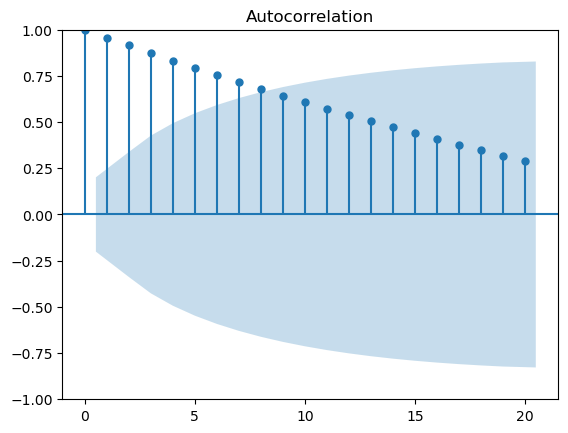

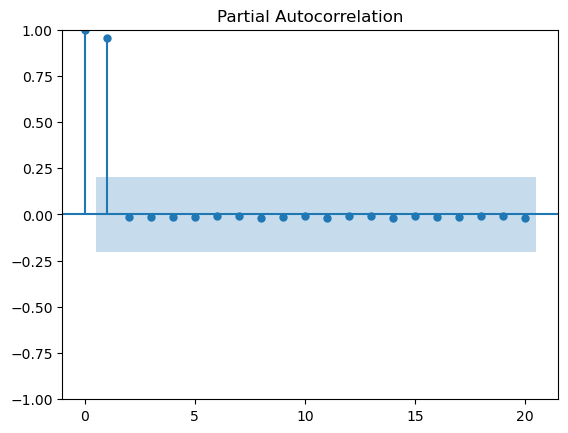

In [67]:
# Plotting ACF and PACF for the errors
plot_acf(errors)
plt.show()
plot_pacf(errors)
plt.show()

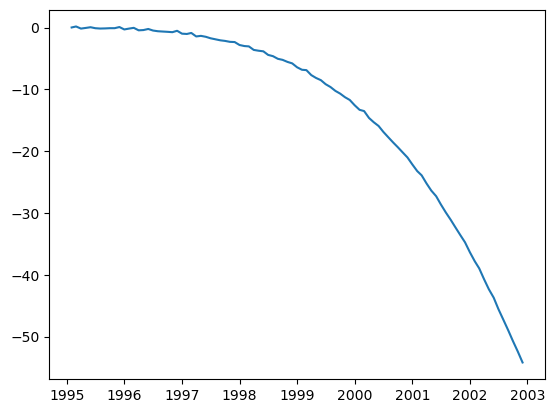

In [68]:
plt.plot(errors)

<Axes: xlabel='log_diff_Passengers', ylabel='Count'>

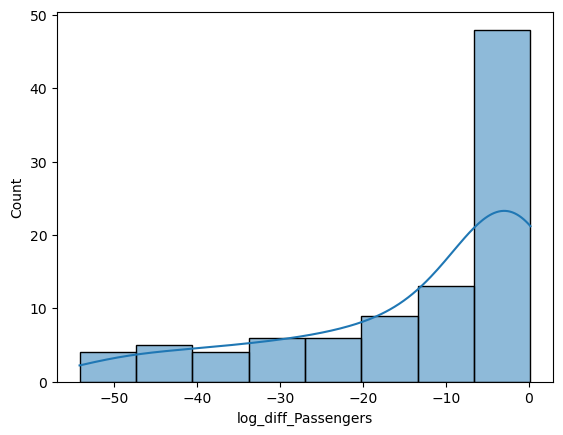

In [69]:
sns.histplot(x = errors, kde = True)

From the above error graphs, we can conclude that there exists a pattern in the errors, and thus or model is not optimal.

Let us try again for p, q used from visual inspection of ACF and PACF plots of stationary data. q should be lag number in ACF that cross error boundary, and p should be lag numbers in PACF that cross error boundary. d should be 0 as we have made our data stationary.

In [70]:
# Defining hyperparameters
p_values = [4, 8, 10, 11, 12]
d_values = [0]
q_values = [4, 8, 12]
evaluate_models(p_values, d_values, q_values)

RMSE=0.09749099656737095 for order (4, 0, 4)
RMSE=0.08641145877093352 for order (4, 0, 8)
RMSE=0.07999361815301353 for order (4, 0, 12)
RMSE=0.06515243966028493 for order (8, 0, 4)
RMSE=0.04223066377285236 for order (8, 0, 8)
RMSE=0.039392261462270886 for order (10, 0, 4)
RMSE=0.03518388447952197 for order (11, 0, 4)
RMSE=0.028720213965258243 for order (11, 0, 8)
RMSE=0.026423507742959162 for order (12, 0, 4)
RMSE=0.02366359023917132 for order (12, 0, 8)
Best Score
RMSE=0.02366359023917132 for order (12, 0, 8)


In [71]:
#Build the ARIMA model on entire stationary data

model = ARIMA(df_st['log_diff_Passengers'], order = (12, 0, 8)).fit()
true = df_st.log_diff_Passengers
pred = model.forecast(steps=len(df_st.log_diff_Passengers)).values
errors = true - pred
print(f"RMSE : {np.sqrt(np.mean((errors)**2))}")

RMSE : 0.0997093976286107


This gave us a much better RMSE score

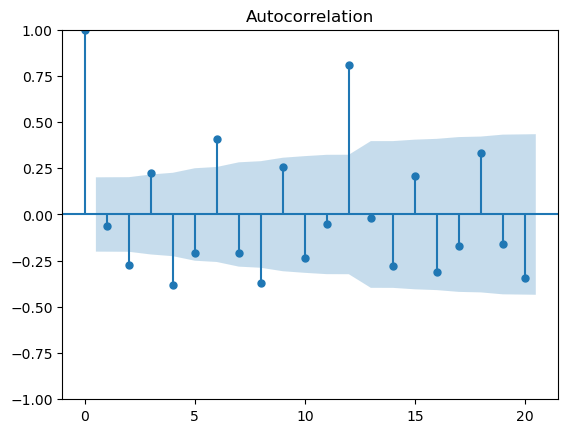

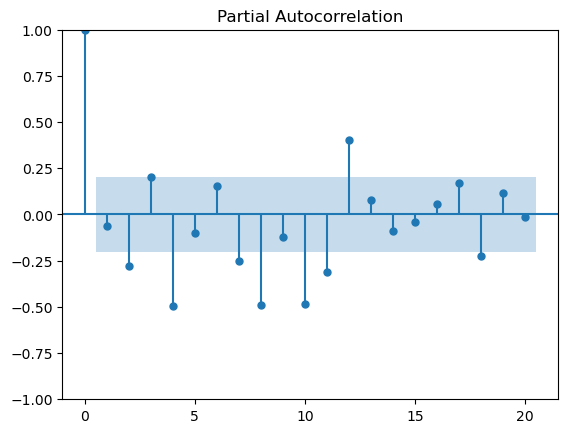

In [74]:
# Plotting ACF and PACF for the errors
plot_acf(errors)
plt.show()
plot_pacf(errors)
plt.show()

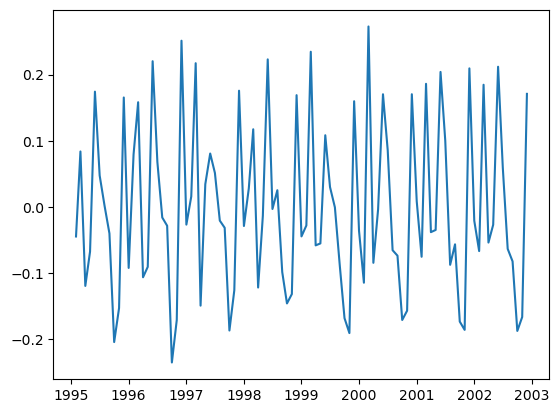

In [75]:
plt.plot(errors)

<Axes: xlabel='log_diff_Passengers', ylabel='Count'>

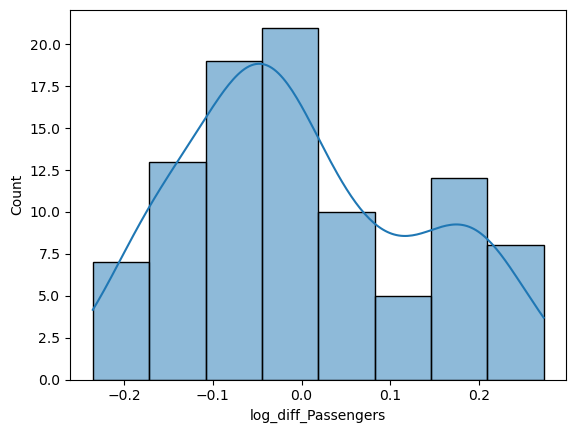

In [76]:
sns.histplot(x = errors, kde = True)

Errors seems random. So our model is optimal.

Our best score is not as good as other models

## Conclusion

- We got the lowest RMSE score of 0.035 for Holt-Winters Exponential Smoothing model with additive seasonality on entire stationary data
- We used log transformation and differenced it to get a stationary timeseries
- We created other dummy variables from month for regression models